In [1]:
import pandas as pd
import numpy as np
import glob
import os
from pathlib import Path
from PIL import Image, ExifTags

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.utils import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import KFold
import scipy

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping
from tensorflow.keras.preprocessing.image import img_to_array, load_img, ImageDataGenerator
from tensorflow.keras.layers import Activation, Dense, GlobalAveragePooling2D, GlobalMaxPooling2D
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import LambdaCallback

#salmon-scales
#from train_util import read_images, load_xy, get_checkpoint_tensorboard, create_model_grayscale, get_fresh_weights, base_output, dense1_linear_output, train_validate_test_split


In [8]:
def base_output(model):
    z = model.output
    z = GlobalMaxPooling2D()(z)
    return z


def dense1_linear_output(gray_model):
    z = base_output(gray_model)
    z = Dense(1, activation='linear')(z)
    return z


def get_checkpoint_tensorboard(tensorboard_path, checkpoint_path):
    tensorboard = TensorBoard(log_dir=tensorboard_path)
    checkpointer = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True, save_weights_only=False)
    return tensorboard, checkpointer


def train_validate_test_split(pairs, validation_set_size=0.15, test_set_size=0.15, a_seed=8):
    """ split pairs into 3 set, train-, validation-, and test-set
        1 - (validation_set_size + test_set_size) = % training set size
    >>> import pandas as pd
    >>> import numpy as np
    >>> data = np.array([np.arange(10)]*2).T  # 2 columns for x, y, and one for index
    >>> df_ = pd.DataFrame(data, columns=['x', 'y'])
    >>> train_x, val_x, test_x = \
             train_validate_test_split( df_, validation_set_size = 0.2, test_set_size = 0.2, a_seed = 1 )
    >>> train_x['x'].values
    array([0, 3, 1, 7, 8, 5])
    >>> val_x['x'].values
    array([4, 6])
    >>> test_x['x'].values
    array([2, 9])
    """
    validation_and_test_set_size = validation_set_size + test_set_size
    validation_and_test_split = validation_set_size / (test_set_size + validation_set_size)
    df_train_x, df_notTrain_x = train_test_split(pairs, test_size=validation_and_test_set_size, random_state=a_seed)
    df_test_x, df_val_x = train_test_split(df_notTrain_x, test_size=validation_and_test_split, random_state=a_seed)
    return df_train_x, df_val_x, df_test_x

# if __name__ == '__main__':
#    image_tensor, age, B4_input_shape = load_images()
#    print(image_tensor.shape)
#    do_train(image_tensor, age, B4_input_shape)

In [2]:
def read_jpg_cods2(B4_input_shape = (380, 380, 3), max_dataset_size = 5180, whichExposure='min'):
    #    '''
    #    reads one .jpg file in each folder in structure of folders
    #    returns tensor with images, and 1-1 correspondence with age
    #    '''

    #max_dataset_size = 5156
    #B4_input_shape = (380, 380, 3)
    df_cod = pd.DataFrame(columns=['age', 'path', 'ExposureTime'])
    image_tensor1 = np.empty(shape=(max_dataset_size,)+B4_input_shape)
    image_tensor2 = np.empty(shape=(max_dataset_size,)+B4_input_shape)
    image_tensor3 = np.empty(shape=(max_dataset_size,)+B4_input_shape)

    base_dir = '/gpfs/gpfs0/deep/data/Savannah_Professional_Practice2021_06_10_21/CodOtholiths-MachineLearning/Savannah_Professional_Practice'
    df_cod = pd.DataFrame(columns=['age', 'path', 'ExposureTime'])
    base_dirs_posix = Path(base_dir)

    error_count=0
    add_count = 0
    for some_year_dir in base_dirs_posix.iterdir():
        count = 0
        if not os.path.isdir( some_year_dir ) or "Extra" in str(some_year_dir):
            continue

        #dir structure: /year/station_number/cod_img_by_age/6 jpeg images of one fish
        stat_nos = [name for name in os.listdir( some_year_dir ) if os.path.isdir(os.path.join(some_year_dir , name))]
        for i in range(0, len(stat_nos)):
            cod_path = os.path.join( some_year_dir, stat_nos[i] )
            yr_station_codage_path = [os.path.join(cod_path , n) for n in os.listdir( cod_path ) 
                            if os.path.isdir(os.path.join(cod_path , n))]
            cod_age = [n for n in os.listdir( cod_path ) 
                            if os.path.isdir(os.path.join(cod_path , n))]

            assert len(yr_station_codage_path) == len(cod_age)
            for j in range(0, len(yr_station_codage_path)):
                #print(onlyfiles)
                onlyfiles = [f for f in os.listdir( yr_station_codage_path[j] ) 
                             if os.path.isfile(os.path.join(yr_station_codage_path[j] , f))]

                #2013/70028/Nr01_age05/Thumbs.db
                #2016/70008/Nr01_age07/Thumbs.db
                if len(onlyfiles) != 6: 
                    #print(str(len(onlyfiles)) + '\t' + str( yr_station_codage_path[j] ) + "\t" +'\t'.join(map(str,onlyfiles)))
                    error_count +=1
                else: 
                    full_path = [os.path.join(yr_station_codage_path[j] , f) 
                             for f in os.listdir( yr_station_codage_path[j] ) 
                         if os.path.isfile(os.path.join(yr_station_codage_path[j] , f))]

                    begin_age = cod_age[j].lower().find('age')
                    #print(cod_age[j])
                    age = cod_age[j][begin_age+3:begin_age+5]
                    try:
                        age = int(age)
                    except ValueError:
                        #print(yr_station_codage_path[j])
                        #print(cod_age[j])
                        #print(age)
                        #print(begin_age)
                        age = 0
                        continue

                    #print(age)

                    full_path.sort()
                    exposures_set = set()
                    exposures_list = []
                    for k in range(0, len(full_path)): #len(full_path) == 6
                        img = Image.open(full_path[k])
                        exif = {ExifTags.TAGS[k]: v for k, v in img._getexif().items() if k in ExifTags.TAGS}
                        #print(exif['ExposureTime'])
                        exposures_set.add( exif['ExposureTime'] )
                        exposures_list.append( exif['ExposureTime'] )


                    #if len(exposures_set) != 3:
                        #print("\t"+str (yr_station_codage_path[j] ) + '\t' + str(exposures_list) ) 
                    #    continue
                    #else:
                    if len(exposures_list) == 6 and len(exposures_set) == 3:

                        expo_args = np.argsort(exposures_list).tolist()
                        #print( "exposures_list"+str(exposures_list) )
                        #print(" argsort: "+str(expo_args) )

                        numpy_images = [0,0,0]
                        file_paths = [0,0,0]
                        imgs_added = 0
                        
                        #use if loading to memory
                        """
                        for k in [0,2,4]:
                            img = Image.open( full_path[ expo_args[k] ] ) 
                            pil_img = load_img(full_path[ expo_args[k] ], target_size=B4_input_shape, grayscale=False)
                            array_img = img_to_array(pil_img, data_format='channels_last')

                            numpy_images[imgs_added] = array_img
                            file_paths[imgs_added] = full_path[ expo_args[k] ]
                            imgs_added += 1
                        """
                        

                        if expo_args != [1, 4, 0, 3, 2, 5]:
                            print( "exposures_list"+str(exposures_list) )
                            print(" argsort: "+str(expo_args) )
                            #print(file_paths)

                        if whichExposure == 'min':
                            #use if loading to memory
                            pil_img = load_img(full_path[ expo_args[0] ], target_size=B4_input_shape, grayscale=False)
                            array_img = img_to_array(pil_img, data_format='channels_last')
                            image_tensor1[add_count] = array_img
                            add_count += 1
                            
                            df_cod = df_cod.append({'age':age, 'path':full_path[expo_args[0]], 'light': 1, 'ExposureTime':exposures_list[expo_args[0]]}, ignore_index=True)
                        if whichExposure == 'middle':
                            #use if loading to memory
                            pil_img = load_img(full_path[ expo_args[2] ], target_size=B4_input_shape, grayscale=False)
                            array_img = img_to_array(pil_img, data_format='channels_last')
                            image_tensor1[add_count] = array_img
                            add_count += 1
                            
                            df_cod = df_cod.append({'age':age, 'path':full_path[expo_args[2]], 'light': 2, 'ExposureTime':exposures_list[expo_args[0]]}, ignore_index=True)
                        if whichExposure == 'max':
                            #use if loading to memory
                            pil_img = load_img(full_path[ expo_args[4] ], target_size=B4_input_shape, grayscale=False)
                            array_img = img_to_array(pil_img, data_format='channels_last')
                            image_tensor1[add_count] = array_img
                            add_count += 1
                            
                            df_cod = df_cod.append({'age':age, 'path':full_path[expo_args[4]], 'light': 3, 'ExposureTime':exposures_list[expo_args[0]]}, ignore_index=True)

                                        

    print("error_count:"+str(error_count))
    print("add_count:"+str(add_count))

    if whichExposure == 'min':
        return image_tensor1, df_cod.age
    if whichExposure == 'middle':
        return image_tensor2, df_cod.age
    if whichExposure == 'max':
        return image_tensor3, df_cod.age

    return None, None



In [3]:
def load_images():
    B4_input_shape = (380, 380, 3)
    B5_input_shape = (456, 456, 3)

    new_shape = B4_input_shape

    new_shape = B5_input_shape
    #B4_input_shape = B5_input_shape

    image_tensor, age = read_jpg_cods2(B4_input_shape, max_dataset_size = 9180) #5316
    
    #image_tensor[5315,:,:,:]
    #image_tensor = image_tensor[0:5315,:,:,:]
    print(len(age))
    print(image_tensor.shape)
    image_tensor = image_tensor[0:len(age),:,:,:] #5114
    
    
    return image_tensor, age, B4_input_shape

In [4]:
image_tensor, age, B4_input_shape = load_images()
print(image_tensor.shape)


exposures_list[0.4, 0.2, 0.1, 0.4, 0.2, 0.1]
 argsort: [2, 5, 1, 4, 0, 3]
exposures_list[0.4, 0.2, 0.1, 0.4, 0.2, 0.1]
 argsort: [2, 5, 1, 4, 0, 3]
exposures_list[0.4, 0.2, 0.1, 0.4, 0.2, 0.1]
 argsort: [2, 5, 1, 4, 0, 3]
exposures_list[0.4, 0.2, 0.1, 0.4, 0.2, 0.1]
 argsort: [2, 5, 1, 4, 0, 3]
exposures_list[0.4, 0.2, 0.1, 0.4, 0.2, 0.1]
 argsort: [2, 5, 1, 4, 0, 3]
exposures_list[0.1, 0.4, 0.2, 0.1, 0.4, 0.2]
 argsort: [0, 3, 2, 5, 1, 4]
exposures_list[0.2, 0.1, 0.4, 0.1, 0.4, 0.2]
 argsort: [1, 3, 0, 5, 2, 4]
exposures_list[0.1, 0.4, 0.2, 0.1, 0.4, 0.2]
 argsort: [0, 3, 2, 5, 1, 4]
exposures_list[0.1, 0.4, 0.2, 0.1, 0.4, 0.2]
 argsort: [0, 3, 2, 5, 1, 4]
exposures_list[0.1, 0.4, 0.2, 0.1, 0.4, 0.2]
 argsort: [0, 3, 2, 5, 1, 4]
exposures_list[0.1, 0.4, 0.2, 0.1, 0.4, 0.2]
 argsort: [0, 3, 2, 5, 1, 4]
exposures_list[0.1, 0.4, 0.2, 0.1, 0.4, 0.2]
 argsort: [0, 3, 2, 5, 1, 4]
exposures_list[0.1, 0.4, 0.2, 0.1, 0.4, 0.2]
 argsort: [0, 3, 2, 5, 1, 4]
exposures_list[0.1, 0.4, 0.2, 0.1, 0.4

exposures_list[0.03333333333333333, 0.125, 0.06666666666666667, 0.03333333333333333, 0.125, 0.06666666666666667]
 argsort: [0, 3, 2, 5, 1, 4]
exposures_list[0.125, 0.06666666666666667, 0.03333333333333333, 0.125, 0.06666666666666667, 0.03333333333333333]
 argsort: [2, 5, 1, 4, 0, 3]
exposures_list[0.03333333333333333, 0.125, 0.06666666666666667, 0.03333333333333333, 0.125, 0.06666666666666667]
 argsort: [0, 3, 2, 5, 1, 4]
exposures_list[0.125, 0.06666666666666667, 0.03333333333333333, 0.125, 0.06666666666666667, 0.03333333333333333]
 argsort: [2, 5, 1, 4, 0, 3]
exposures_list[0.125, 0.06666666666666667, 0.03333333333333333, 0.125, 0.06666666666666667, 0.03333333333333333]
 argsort: [2, 5, 1, 4, 0, 3]
exposures_list[0.125, 0.06666666666666667, 0.03333333333333333, 0.125, 0.06666666666666667, 0.03333333333333333]
 argsort: [2, 5, 1, 4, 0, 3]
exposures_list[0.125, 0.06666666666666667, 0.03333333333333333, 0.125, 0.06666666666666667, 0.03333333333333333]
 argsort: [2, 5, 1, 4, 0, 3]
exposu

In [5]:
def base_model( B4_input_shape ):
    ############# Define model ################
    data_augmentation = tf.keras.Sequential([
      layers.experimental.preprocessing.RandomFlip("horizontal"),
      layers.experimental.preprocessing.RandomRotation(factor=(-0.5, 0.5))],
      name="img_augmentation",
      # possible width shift, height shift  
    )

    rgb_efficientNetB4 = tf.keras.applications.EfficientNetB4(include_top=False, weights='imagenet',
                                                              input_shape=B4_input_shape, classes=2)
    z = dense1_linear_output( rgb_efficientNetB4 )
    cod_tmp = Model(inputs=rgb_efficientNetB4.input, outputs=z) 
    

    inputLayer = tf.keras.layers.Input(shape=B4_input_shape)
    x = data_augmentation(inputLayer)  
    x = cod_tmp(x)
    cod = Model(inputs=inputLayer, outputs=x) 

    print(cod.summary())
    return cod

In [6]:
def binary_accuracy_for_regression(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)), axis=-1)

def compile_model( cod ):
    ########### Compile model ##################
    learning_rate = 0.00001  # 0.00005
    adam = optimizers.Adam(learning_rate=learning_rate)

    for layer in cod.layers:
        layer.trainable = True

    cod.compile(loss='mse', optimizer=adam, metrics=['mse', 'mape', binary_accuracy_for_regression])

<class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 380, 380, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 380, 380, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 380, 380, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 380, 380, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 380, 380, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 380, 380, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 380, 380, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 380, 380, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 380, 380, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 380, 380, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 380, 380, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 380, 380, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 380, 380, 3)
<class 'tensorflow.python.framework.ops.EagerTensor'>
(1, 380, 380, 3)
<class

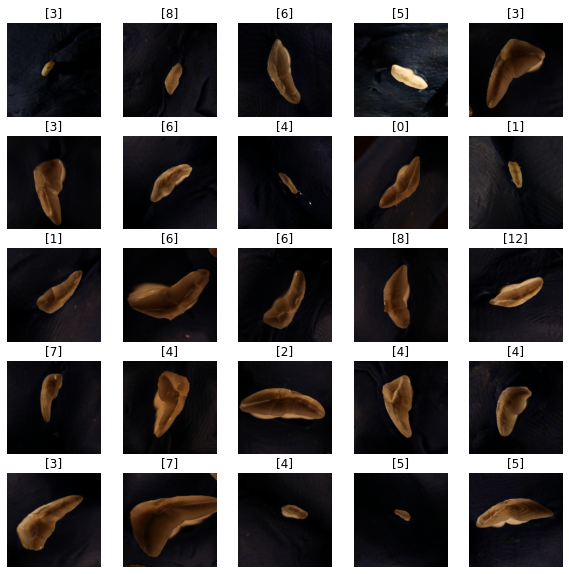

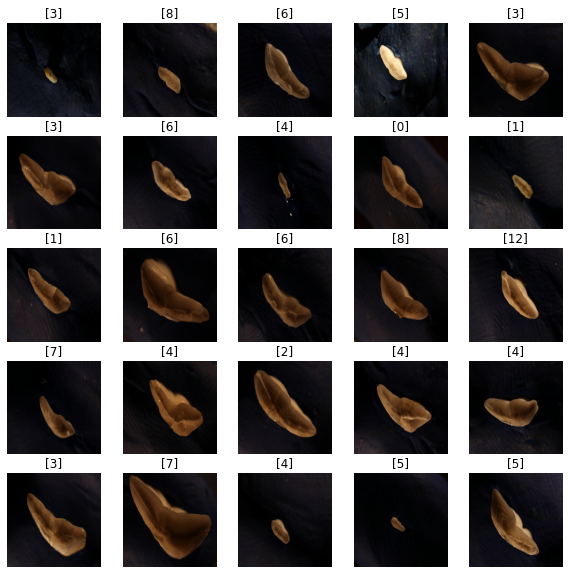

In [16]:
import matplotlib.pyplot as plt

####### Train/Test split ################################
train_idx, val_idx, test_idx = train_validate_test_split(range(0, len(image_tensor)))

train_idx_oof = train_idx + val_idx  # prepare - train+validation set for 5 KFold cv split
val_idx = None

train_rb_imgs = np.empty(shape=(len(train_idx_oof),) + B4_input_shape)  # shape=(len(train_idx),)+B4_input_shape)
train_age = []
for i in range(0, len(train_idx_oof)):  # train_idx)):
    train_rb_imgs[i] = image_tensor[train_idx_oof[i]]  # train_idx[i]]
    train_age.append(age[train_idx_oof[i]])  # train_idx[i]])

test_rb_imgs = np.empty(shape=(len(test_idx),) + B4_input_shape)
test_age = []
for i in range(0, len(test_idx)):
    test_rb_imgs[i] = image_tensor[test_idx[i]]
    test_age.append(age[test_idx[i]])

test_age = np.vstack(test_age)
age = np.vstack(age)

test_rb_imgs = np.multiply(test_rb_imgs, 1. / 255)
train_rb_imgs = np.multiply(train_rb_imgs, 1. / 255) #Train- + Validation images

######################################################
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal"),
  layers.experimental.preprocessing.RandomRotation(factor=(-0.5, 0.5))],
  name="img_augmentation",
)
########## print image after augmentation ################
image_batch, label_batch = next(iter(train_dataset))

plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    augmented_image = data_augmentation(tf.expand_dims(train_rb_imgs[n], axis=0)) #image_batch[n], 0))
    print(type(augmented_image))
    print( augmented_image.shape)
    plt.imshow( augmented_image[0] ) #.numpy())
    plt.title( test_age[n] ) # .numpy() )# .decode("utf-8"))
    plt.axis('off')
    
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow( train_rb_imgs[n] )
    plt.title( test_age[n] ) 
    plt.axis('off')    

In [17]:
def do_train(image_tensor, age, B4_input_shape):
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    tensorboard_path = './tensorboard_test2'
    checkpoint_path = './checkpoints_test2/cod_oto_efficientnetBBB.{epoch:03d}-{val_loss:.2f}.hdf5'
    a_batch_size = 16

    B4_input_shape = (380, 380, 3)
    B5_input_shape = (456, 456, 3)

    new_shape = B4_input_shape
    
    
    ############## pretrain salmon_scales ###############
    '''
    new_shape = (380, 380, 3)
    age_cod = age
    rb_imgs, all_sea_age, all_smolt_age, all_farmed_class, all_spawn_class, all_filenames = load_xy()
    
    uten_ukjent = len(all_sea_age) - all_sea_age.count(-1.0)
    rb_imgs2 = np.empty(shape=(uten_ukjent,)+new_shape)
    unique, counts = np.unique(all_sea_age, return_counts=True)
    print("age distrib:"+str( dict(zip(unique, counts)) ))
    
    all_sea_age2 = []
    found_count = 0
    all_filenames2 = []
    for i in range(0, len(all_sea_age)):
        if all_sea_age[i] > -1:
            rb_imgs2[found_count] = rb_imgs[i]
            all_sea_age2.append(all_sea_age[i])
            found_count += 1
            all_filenames2.append(all_filenames[i])
    
    assert found_count == uten_ukjent
    
    age_scales = all_sea_age2
    rb_imgs = rb_imgs2
    
    age_scales = np.vstack(age_scales)
    
    train_datagen_scales = ImageDataGenerator(
        zca_whitening=False,
        width_shift_range=0.2,
        height_shift_range=0.2, #20,
        #zoom_range=[0.5,1.0],
        rotation_range=360,
        horizontal_flip=False,
        vertical_flip=True,
        rescale=1./255)
    
    train_generator_scales = train_datagen_scales.flow(rb_imgs, age_scales, batch_size= a_batch_size)
    history_callback_scales = cod.fit(train_generator_scales,
        steps_per_epoch=1000,
        epochs=20,
        #callbacks=[early_stopper, tensorboard, checkpointer],
        #validation_data= (val_rb_imgs, val_age),
        class_weight=classWeight)
    
    cod.save("NNSalmonScales/salmonNNmodel.h5")
    print("Saved salmon model to disk")
    '''
    


    ######### Run KFold ####################
    test_predictions_nn = np.zeros(test_age.shape[0])    
    the_fold = 0
    # K-fold
    a_seed = 2021
    numberOfFolds = 5
    kfold = KFold(n_splits= numberOfFolds, random_state=a_seed, shuffle=True)
    for fold, (trn_ind, val_ind) in enumerate(kfold.split(train_age)):
        train_idx = trn_ind
        val_idx = val_ind
    
        train_rb_imgs_new = np.empty(shape=(len(train_idx),) + B4_input_shape)
        train_age_new = []
        for i in range(0, len(train_idx)):
            train_rb_imgs_new[i] = train_rb_imgs[train_idx[i]]
            train_age_new.append(train_age[train_idx[i]])
    
        val_rb_imgs_new = np.empty(shape=(len(val_idx),) + B4_input_shape)
        val_age_new = []
        for i in range(0, len(val_idx)):
            val_rb_imgs_new[i] = train_rb_imgs[val_idx[i]]
            val_age_new.append(train_age[val_idx[i]])
    
        train_age_new = np.vstack(train_age_new)
        val_age_new = np.vstack(val_age_new)
    
        ######################################################
        train_dataset = tf.data.Dataset.from_tensor_slices((train_rb_imgs_new, np.vstack(train_age_new)))
        train_dataset = train_dataset.shuffle(len(train_age_new))
        train_dataset = train_dataset.batch(a_batch_size)
        train_dataset = train_dataset.repeat(1000)
            
        ############ build, compile model ####################
        cod = base_model(B4_input_shape)
        compile_model(cod)
        ############ CallBacks ##############################
        tensorboard, checkpointer = get_checkpoint_tensorboard(tensorboard_path, checkpoint_path)
        
        early_stopper = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=0,
            mode = 'min', restore_best_weights = True)
        plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=7,
            verbose = 0, mode = 'min')
    
        log_file_name = 'loss_log/loss_log2_'+str(the_fold)+'.txt'
        print( "log_file_name:"+str(log_file_name) )
        txt_log = open(log_file_name, mode='wt', buffering=1)

        save_op_callback = LambdaCallback(
          on_epoch_end = lambda epoch, logs: txt_log.write(
            str( {'epoch': epoch, 'loss': logs['loss']} ) + '\n'),
          on_train_end = lambda logs: txt_log.close()
        )
    

    
        K.set_value(cod.optimizer.learning_rate, 0.00001)
        print("Learning rate before second fit:", cod.optimizer.learning_rate.numpy())
    
        history_callback = cod.fit(train_dataset,
                                   steps_per_epoch=1600,
                                   epochs=150,
                                   callbacks=[
                                       early_stopper, 
                                       plateau,
                                       tensorboard, 
                                       checkpointer,
                                       save_op_callback],
                                   validation_data=(val_rb_imgs_new, val_age_new),  # (val_rb_imgs, val_age),
                                   class_weight=None)
    
        test_metrics = cod.evaluate(x=test_rb_imgs, y=test_age)  # np.vstack(test_age)
        print("test metric:" + str(cod.metrics_names))
        print("test metrics:" + str(test_metrics))
    
        print("precision, recall, f1")
        y_pred_test = cod.predict(test_rb_imgs, verbose=1)
        test_predictions_nn += y_pred_test / numberOfFolds
        
        ###### Save model #############
        # serialize weights to HDF5
        cod.save("EffNetB4/EffNetB4_{}.h5".format( the_fold ))
        print("Saved model to disk")
        
        y_pred_test_bool = np.argmax(y_pred_test, axis=1)
        y_true_bool = np.argmax(test_age, axis=1)
        # np.argmax inverse of to_categorical
        argmax_test = np.argmax(test_age, axis=1)
        unique, counts = np.unique(argmax_test, return_counts=True)
        print("test ocurrence of each class:" + str(dict(zip(unique, counts))))
    
        print("cslassification_report")
        print(classification_report(y_true_bool, y_pred_test_bool))
        print("confusion matrix")
        print(str(confusion_matrix(y_true_bool, y_pred_test_bool)))

    return test_predictions_nn




In [ ]:
test_predictions_nn = do_train(image_tensor, age, B4_input_shape)

print(test_predictions_nn)
test_age

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 380, 380, 3)]     0         
_________________________________________________________________
img_augmentation (Sequential (None, 380, 380, 3)       0         
_________________________________________________________________
model (Functional)           (None, 1)                 17675616  
Total params: 17,675,616
Trainable params: 17,550,409
Non-trainable params: 125,207
_________________________________________________________________
None
log_file_name:loss_log/loss_log2_0.txt
Learning rate before second fit: 1e-05


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 1/150
 593/1600 [==========>...................] - ETA: 8:44 - loss: 16.7225 - mse: 16.7225 - mape: 4127699.7500 - binary_accuracy_for_regression: 0.1371

In [ ]:
from sklearn.metrics import mean_squared_error, accuracy_score
  

mse = mean_squared_error(test_age, test_predictions_nn)
print(mse)


acc = accuracy_score(test_age, int(round(test_predictions_nn)))
print(acc)